In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from netCDF4 import num2date,date2num,Dataset
import scipy,matplotlib
import pyart
import copy
import os, subprocess, time
from joblib import Parallel, delayed
import datetime
from marcus_py_tools import walklevel,latlon_from_xy
%matplotlib inline

In [2]:
alt_melt_020130608 = 4572. #..This is roughly the same for 6/19 as well

In [3]:
#..with doing kdp
def nexrad_to_gridnc(filenm1,path='./',extend_melt=False,newpre='grid02_khgx_',alt_rad=4000.):

    radarraw  = pyart.io.read_nexrad_archive(path+filenm1)
#   nswp      = radarraw.nsweeps
#   swp_arr   = range(nswp)
#   swp_arr.remove(1)
#   swp_arr.remove(3)
#   swp_arr.remove(5)
#   print swp_arr
#   radarobsall = radarraw.extract_sweeps(swp_arr)
    radarobsall = radarraw


    ref_name    = 'reflectivity'
    dphase_name = 'differential_phase'
    rho_name    = 'cross_correlation_ratio'
    zdr_name    = 'differential_reflectivity'
    kdp_name    = 'kdp'
    dphase_rname= 'phidp'
    filenm=filenm1

    rad_epoc = (datetime.datetime(int(filenm[4:8]),int(filenm[8:10]),int(filenm[10:12]),
                           int(filenm[13:15]),int(filenm[15:17]),int(filenm[17:19])) -
              datetime.datetime(1970,1,1)).total_seconds()


    if extend_melt:
        alt_rad += 3000.    #..Relax melting-layer assumption to allow for lofted rain
    else:
        pass

    print '........................'

    #..Fix KDP
    #coh_pwr=copy.deepcopy(radarobsall.fields['PHI'])
    coh_pwr=copy.deepcopy(radarobsall.fields[dphase_name])
    coh_pwr['data'] = coh_pwr['data']*0.+1.
    radarobsall.fields['norm_coherent_power'] = coh_pwr
    phidp,kdp = pyart.correct.phase_proc_lp(radarobsall,0.0,
                                          refl_field=ref_name,
                                          LP_solver='cylp',
                                          ncp_field='norm_coherent_power',
                                          rhv_field=rho_name,
                                          phidp_field=dphase_name,
                                          fzl = alt_rad,
                                          coef=.87,
                                          low_z=25.)
    radarobsall.fields[dphase_rname] = phidp
    radarobsall.fields[kdp_name] = kdp

    print 'done with LP phase correction!'

    #..Do gridding
    #newpre = 'gridfalt_kvnx_'
    #newpre = 'grid1_kvnx_'
    newmid = filenm1[4:19]

    radarobs = (radarobsall,)

    grid_ref = pyart.map.grid_from_radars(radarobsall,(30,400,400),
                       ((0.,15000.),(-200000.,200000.),(-200000.,200000.)),
                       fields=[rho_name,ref_name,zdr_name,dphase_rname,kdp_name],
                       refl_field=ref_name,roi_func='dist_beam',
                       h_factor=0.,nb=0.6,bsp=1.,min_radius=200.)     #..New (post 4/10/2016) settings 02
                       #h_factor=0.,nb=0.5,bsp=1.,min_radius=100.)    #..New (post 4/6/2016) settings 01
                       #h_factor=.8,nb=1.2,bsp=.8)   #..Old (pre 4/6/2016) settings
                       #roi_func='dist_beam')   #..Remove for earlier versions of pyart

    print 'done with gridding!'

    pyart.io.write_grid(path+newpre+newmid+'.nc',grid_ref,'NETCDF4')

    print 'done writing grid to netcdf'

In [4]:
def gridthemall(numjobs,path='./',alt_rad=4000.,startstr='KVNX2011',out_pre='grid2_kvnx',ex_mlt=False):
    wsrfiles = []
    numfiles = 0
    for root,dirs,files in walklevel(path):
        for file in files:
            if file.startswith(startstr):
                wsrfiles.append(file)
                numfiles += 1

    #..Run for multiple processors
    Parallel(n_jobs=numjobs, 
             verbose=5)(delayed(nexrad_to_gridnc)(wsrfiles[i],path=path,
                                                  newpre=out_pre,alt_rad=alt_rad,
                                                 extend_melt=ex_mlt) for i in range(numfiles))

    print 'all done!'

In [ ]:
#gridthemall(5,path='/mnt/raid/mvanlier/nexrad_kvnx_524/')
#gridthemall(5,path='/mnt/raid/mvanlier/nexrad_kvnx_523/')
#gridthemall(5,path='/mnt/raid/mvanlier/nexrad_kvnx_425/latedata/')
#gridthemall(5,path='/mnt/raid/mvanlier/nexrad_kvnx_520/stage_data_after15UTC/')
#gridthemall(5,path='/mnt/raid/mvanlier/nexrad_gua_20150515/')
#gridthemall(5,path='/mnt/raid/mvanlier/nexrad_khgx/20130608/',alt_rad=10000.)
gridthemall(5,path='/mnt/raid/mvanlier/nexrad_khgx/20130619/0002/',startstr='KHGX2013',alt_rad=10000.,
            out_pre='grid01_khgx_')
#gridthemall(5,path='/mnt/raid/mvanlier/nexrad_khgx/20130619/0002/',alt_rad=10000.)
#gridthemall(5,path='/mnt/raid/mvanlier/nexrad_khgx/20130722/',alt_rad=10000.)
#..

........................
........................
........................


/home/mvanlier/anaconda/lib/python2.7/site-packages/pyart/correct/phase_proc.py:189: RuntimeWarning: invalid value encountered in divide
  return abs(signal) / noise
/home/mvanlier/anaconda/lib/python2.7/site-packages/pyart/correct/phase_proc.py:435: RuntimeWarning: invalid value encountered in less
  my_rhv[radial, :] < rhohv_lev), my_snr < 10.0)
/home/mvanlier/anaconda/lib/python2.7/site-packages/pyart/correct/phase_proc.py:189: RuntimeWarning: invalid value encountered in divide
  return abs(signal) / noise
/home/mvanlier/anaconda/lib/python2.7/site-packages/pyart/correct/phase_proc.py:435: RuntimeWarning: invalid value encountered in less
  my_rhv[radial, :] < rhohv_lev), my_snr < 10.0)


........................


/home/mvanlier/anaconda/lib/python2.7/site-packages/pyart/correct/phase_proc.py:189: RuntimeWarning: invalid value encountered in divide
  return abs(signal) / noise
/home/mvanlier/anaconda/lib/python2.7/site-packages/pyart/correct/phase_proc.py:435: RuntimeWarning: invalid value encountered in less
  my_rhv[radial, :] < rhohv_lev), my_snr < 10.0)


........................


/home/mvanlier/anaconda/lib/python2.7/site-packages/pyart/correct/phase_proc.py:189: RuntimeWarning: divide by zero encountered in divide
  return abs(signal) / noise
/home/mvanlier/anaconda/lib/python2.7/site-packages/pyart/correct/phase_proc.py:189: RuntimeWarning: invalid value encountered in divide
  return abs(signal) / noise
/home/mvanlier/anaconda/lib/python2.7/site-packages/pyart/correct/phase_proc.py:435: RuntimeWarning: invalid value encountered in less
  my_rhv[radial, :] < rhohv_lev), my_snr < 10.0)
/home/mvanlier/anaconda/lib/python2.7/site-packages/pyart/correct/phase_proc.py:189: RuntimeWarning: divide by zero encountered in divide
  return abs(signal) / noise
/home/mvanlier/anaconda/lib/python2.7/site-packages/pyart/correct/phase_proc.py:189: RuntimeWarning: invalid value encountered in divide
  return abs(signal) / noise
/home/mvanlier/anaconda/lib/python2.7/site-packages/pyart/correct/phase_proc.py:435: RuntimeWarning: invalid value encountered in less
  my_rhv[radial

In [ ]:
gridthemall(5,path='/mnt/raid/mvanlier/nexrad_kvnx_520/latedata/',alt_rad=10000.,startstr='KVNX20110520',
            out_pre='grid2_kvnx')

In [ ]:
print 'test'

In [10]:
nexrad_to_gridnc('KVNX20110520_112410_V06',path='/mnt/raid/mvanlier/nexrad_kvnx_520/',extend_melt=True)

[0, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
........................
done with LP phase correction!
done with gridding!
done writing grid to netcdf


/home/mvanlier/anaconda/lib/python2.7/site-packages/pyart/correct/phase_proc.py:187: RuntimeWarning: invalid value encountered in divide
  return abs(signal) / noise
/home/mvanlier/anaconda/lib/python2.7/site-packages/pyart/correct/phase_proc.py:433: RuntimeWarning: invalid value encountered in less
  my_rhv[radial, :] < rhohv_lev), my_snr < 10.0)


In [10]:
filepre  = 'grid00_khgx'
basepath = '/home/mvanlier/mvanlier/nexrad_khgx/20130619/'
radr_lat = 29.468
radr_lon = -95.075

filess = []
numfiles  = 0
for root,dirs,files in walklevel(basepath,level=0):
    for file in files:
        if file.startswith(filepre):
            filess.append(file)
            numfiles += 1
filess = sorted(filess)


#..
filenm = filess[0]
nc = Dataset(basepath+filenm,'r')
#..Let's throw in (dry bulb) temperature because why not
xd = nc.variables['x_disp'][:]
yd = nc.variables['y_disp'][:]
nc.close()
#..
lat_grid,lon_grid = latlon_from_xy(xd,yd,radr_lat,radr_lon)
#..
for i in xrange(numfiles):
    filenm = filess[i]
    nc = Dataset(basepath+filenm,'r+')
    lon_gr = nc.createVariable('lon_grid','f',dimensions=('ny', 'nx'))
    lon_gr[:,:] = lon_grid
    lon_gr.long_name = 'Longitude grid'
    lon_gr.units = 'deg'
    lon_gr.valid_max = 180.
    lon_gr.valid_min = -180.
    #..
    lat_gr = nc.createVariable('lat_grid','f',dimensions=('ny', 'nx'))
    lat_gr[:,:] = lat_grid
    lat_gr.long_name = 'Latitude grid'
    lat_gr.units = 'deg'
    lat_gr.valid_max = 90.
    lat_gr.valid_min = -90.
    #..
    nc.close()
    

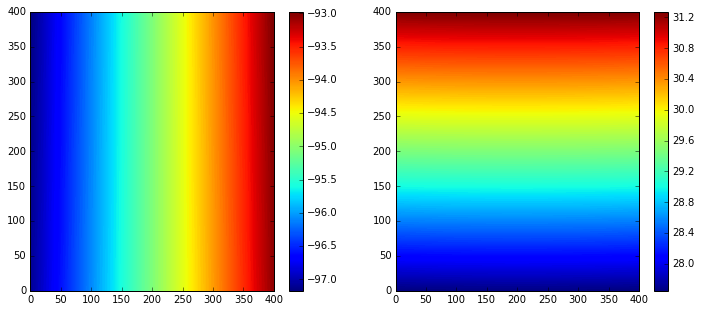

In [8]:
nc = Dataset('/home/mvanlier/mvanlier/nexrad_khgx/20130722/grid00_khgx_20130722_150046.nc')
lng = nc.variables['lon_grid'][:,:]
ltg = nc.variables['lat_grid'][:,:]
nc.close()

fig=plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
pg = ax.pcolormesh(lng)
plt.colorbar(pg)
ax = fig.add_subplot(122)
pg =ax.pcolormesh(ltg)
plt.colorbar(pg)